# Burgers Equation Identification Using PINN-L-BFGS
Equation:   $u_{t} + \lambda_1 uu_{x}-\lambda_2 u_{xx} = 0$  

In [37]:
#author : $um@nth
import torch
import torch.nn as nn
import numpy as np
from torch.autograd import grad
import scipy.io
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [38]:
N_u = 2500
layers = [2, 25, 25, 25, 25, 25, 25, 25, 25, 1]
data = scipy.io.loadmat('burgers_shock.mat') 
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T
X, T = np.meshgrid(x,t)
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))                  
u_star = Exact.flatten()[:,None]                                                 
lb = X_star.min(0)                                                              
ub = X_star.max(0)
np.random.seed(107)
idx = np.random.choice(X_star.shape[0], N_u, replace=False)

X_train = X_star[idx,:]
u_train = torch.from_numpy(u_star[idx,:]).float()
X = torch.from_numpy(X_train[:,0:1]).requires_grad_(True).float()     
T = torch.from_numpy(X_train[:,1:2]).requires_grad_(True).float()

In [39]:
class PINN(nn.Module):

  def __init__(self, layers):
    super(PINN, self).__init__()
    self.layers = nn.ModuleList()
    for i, j in zip(layers, layers[1:]):
      linear = nn.Linear(i, j)
      nn.init.xavier_normal_(linear.weight.data, gain = 1.0)
      nn.init.zeros_(linear.bias.data)
      self.layers.append(linear)
  
  def forward(self, x):
    L = len(self.layers)
    for l, transform in enumerate(self.layers):
      if l < L-1:
        x = torch.tanh(transform(x))
      else:
        x = transform(x)
    return x   

In [40]:
class PINN_Run():

  def __init__(self, X, T, model, u_train):
    self.X = X
    self.T = T
    self.u_train = u_train
    self.model = model
    self.i = 0
    self.l1_error = []
    self.l2_error = []
    self.l1 = nn.Parameter(torch.tensor([0.], requires_grad=True))
    self.l2 = nn.Parameter(torch.tensor([0.], requires_grad=True))
    self.model.register_parameter('lambda_1', self.l1)
    self.model.register_parameter('lambda_2', self.l2)
    self.optimizer = torch.optim.LBFGS(
            self.model.parameters(), 
            lr = 1, 
            max_iter = 20000, 
            max_eval = 20000, 
            history_size = 50,
            tolerance_grad = 1e-6, 
            tolerance_change = 1.0 * np.finfo(float).eps,
            line_search_fn = "strong_wolfe"
        )
  
  def residual_loss(self):
    xf = torch.cat([self.X, self.T], axis=1)
    uf = self.model(xf)
    u_x = grad(uf.sum(), self.X, retain_graph = True, create_graph = True)[0]
    u_xx = grad(u_x.sum(), self.X, retain_graph = True, create_graph = True)[0]
    u_t = grad(uf.sum(), self.T, retain_graph = True, create_graph = True)[0]
    f = u_t + self.l1*uf*u_x - self.l2*u_xx 
    return torch.mean(torch.square(f))
  
  def closure(self):
    self.model.train()
    mse = nn.MSELoss()
    self.optimizer.zero_grad()
    yhat = self.model(torch.cat([self.X, self.T], axis=1).float())
    loss1 = mse(yhat, self.u_train)
    loss2 = self.residual_loss()
    loss = loss1 + loss2
    loss.backward()
    nu = 0.01/np.pi
    error_lambda_1 = np.abs(self.l1.detach().numpy() - 1.0)*100
    error_lambda_2 = np.abs(self.l2.detach().numpy() - nu)/nu * 100
    self.l1_error.append(error_lambda_1[0])
    self.l2_error.append(error_lambda_2[0])
    if self.i % 100 == 0:
      print('Epoch:', self.i, 'Loss: %.5e, Lambda_1: %.5f, Lambda_2: %.5f' % (loss.item(), self.l1, self.l2))
    self.i += 1
    return loss
  
  def train_(self):
    self.optimizer.step(self.closure)

In [41]:
pinn_model = PINN(layers)
pinn_ = PINN_Run(X, T, pinn_model, u_train)
pinn_.train_()

Epoch: 0 Loss: 3.74209e-01, Lambda_1: 0.00000, Lambda_2: 0.00000
Epoch: 100 Loss: 2.83168e-02, Lambda_1: 0.08026, Lambda_2: 0.00054
Epoch: 200 Loss: 2.28425e-02, Lambda_1: 0.27738, Lambda_2: 0.00203
Epoch: 300 Loss: 1.60742e-02, Lambda_1: 0.42906, Lambda_2: 0.00248
Epoch: 400 Loss: 1.12777e-02, Lambda_1: 0.62037, Lambda_2: 0.00319
Epoch: 500 Loss: 9.07059e-03, Lambda_1: 0.69135, Lambda_2: 0.00420
Epoch: 600 Loss: 7.08503e-03, Lambda_1: 0.76823, Lambda_2: 0.00479
Epoch: 700 Loss: 5.99593e-03, Lambda_1: 0.81601, Lambda_2: 0.00545
Epoch: 800 Loss: 4.52173e-03, Lambda_1: 0.83184, Lambda_2: 0.00569
Epoch: 900 Loss: 3.77591e-03, Lambda_1: 0.84848, Lambda_2: 0.00519
Epoch: 1000 Loss: 3.06655e-03, Lambda_1: 0.84794, Lambda_2: 0.00471
Epoch: 1100 Loss: 7.06287e-03, Lambda_1: 0.87947, Lambda_2: 0.00480
Epoch: 1200 Loss: 2.37530e-03, Lambda_1: 0.84854, Lambda_2: 0.00471
Epoch: 1300 Loss: 2.09285e-03, Lambda_1: 0.86900, Lambda_2: 0.00473
Epoch: 1400 Loss: 1.85941e-03, Lambda_1: 0.89035, Lambda_2: 

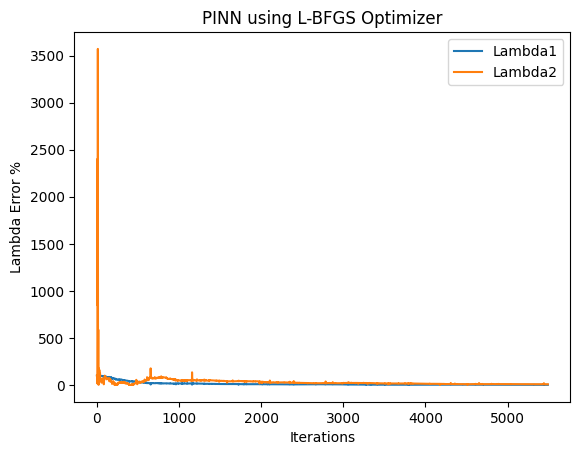

In [66]:
plt.plot(np.arange(1, 5492), np.array(pinn_.l1_error), label='Lambda1')
plt.plot(np.arange(1, 5492), np.array(pinn_.l2_error), label='Lambda2')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Lambda Error %')
plt.title('PINN using L-BFGS Optimizer')
plt.show()

In [47]:
lambda1 = float(pinn_model.lambda_1.data)
lambda2 = float(pinn_model.lambda_2.data)
print('Lambda1 Pred:', round(lambda1,8), '  ; Lambda1 Actual:', 1.0)
print('Lambda2 Pred:', round(lambda2,8), '  ; Lambda2 Actual:', round(0.01/np.pi,8))

Lambda1 Pred: 0.99005514   ; Lambda1 Actual: 1.0
Lambda2 Pred: 0.0034076   ; Lambda2 Actual: 0.0031831


In [52]:
from torchsummary import summary

summary(pinn_model, input_size=(2,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 25]              75
            Linear-2                   [-1, 25]             650
            Linear-3                   [-1, 25]             650
            Linear-4                   [-1, 25]             650
            Linear-5                   [-1, 25]             650
            Linear-6                   [-1, 25]             650
            Linear-7                   [-1, 25]             650
            Linear-8                   [-1, 25]             650
            Linear-9                    [-1, 1]              26
Total params: 4,651
Trainable params: 4,651
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.02
-----------------------------------------------